THINGS TO CHECK
- check rescale
- load on demand vs load on init

In [1]:
import sys
sys.path.append('../src')

import albumentations as A
import random
import numpy as np
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation, OneFormerConfig
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata
from safetensors.torch import load_model, save_model
from config import DATASET_DIR, CLASS_INFO_PATH, MAIN_PROJECT_DIR, GALAXY_MEAN, GALAXY_STD
from visual import *
from dataset import *
from utils import *

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
torch.cuda.is_available()

True

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
id2label, label2id = get_id2label_mappings()

config = OneFormerConfig.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny", 
                                         num_classes = len(id2label),
                                         id2label = id2label,
                                         label2id = label2id,
                                         is_training=True)


/home/panzaresce/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# model_card = "shi-labs/oneformer_coco_dinat_large"
model_card = "shi-labs/oneformer_ade20k_swin_tiny"
model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
processor = OneFormerProcessor.from_pretrained(model_card)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

In [7]:
# Uncomment to load from fine-tuned model
# load_model(model, "../safetensors/model.safetensors")

In [5]:
# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well. 
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

In [9]:
MAIN_PROJECT_DIR

'/home/panzaresce/repos/galaxy_segmentation'

In [8]:
# Augmentations
transform = A.Compose([
    A.OneOf([
        A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.OneOf([
                A.Rotate(limit=(90), p=1),
                A.Rotate(limit=(180), p=1),
                A.Rotate(limit=(270), p=1)
            ], p=1)
        ]),
        A.NoOp()
    ], p=1.0)
])

In [9]:
dataset_train = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [11]:
dataset_val = GalaxyDataset(DATASET_DIR, "val", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [12]:
dataset_test = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [9]:
dataset_sub = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=20)

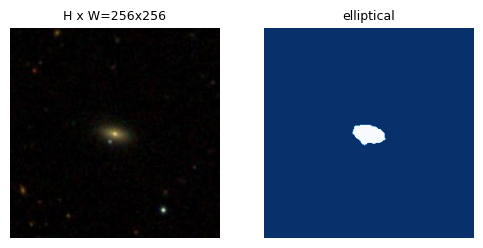

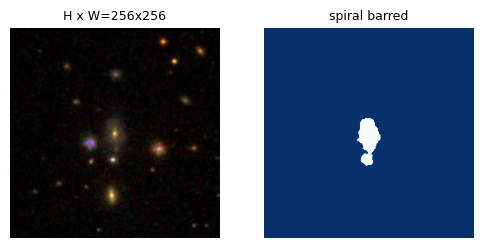

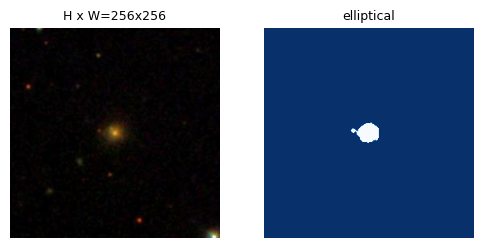

In [27]:
display_n_samples(dataset_train, 3)

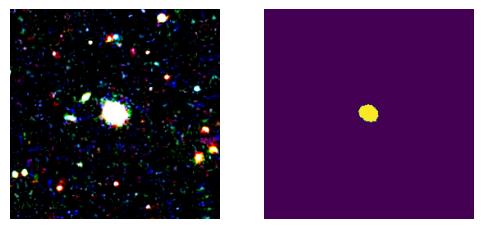

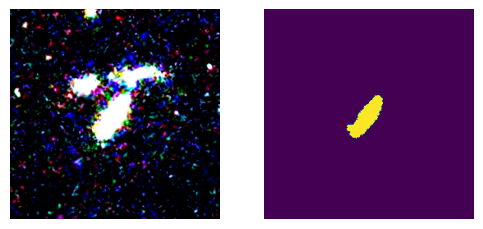

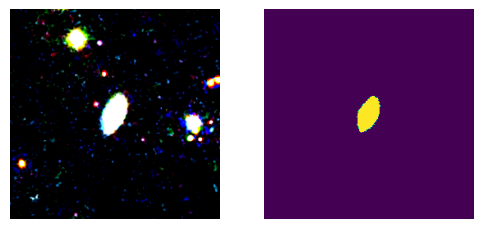

In [15]:
display_n_samples(dataset_train, 3, False)

In [ ]:
batch_size = 1
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
train_dataloader = DataLoader(dataset_sub, batch_size=1, shuffle=False)

In [ ]:
n_epochs = 2
starting_epoch = 0
verbose = True

lr_schedule = [5e-5, 5e-6]

tr_loss = []
val_loss = []

training_steps = 0
model.to(device)
for epoch in range(starting_epoch, n_epochs):
  print(f"Epoch {epoch+1}, lr = {lr_schedule[epoch]}")
  optimizer = AdamW(model.parameters(), lr=lr_schedule[epoch])
  model.train()
  model.model.is_training = True

  tr_running_loss = 0.0

  for batch_idx, batch in enumerate(train_dataloader):
    training_steps += 1
    
    optimizer.zero_grad()

    batch = {k:v.to(device) for k,v in batch.items()}
    outputs = model(**batch)

    print(batch.keys())
    tr_running_loss += outputs.loss.item()
    
    avg_loss = tr_running_loss / (batch_idx + 1)
    tr_loss.append(avg_loss)
    
    # print every 5% of progress
    if verbose or (batch_idx + 1) % (len(train_dataloader) // 20) == 0 or batch_idx < 10 :
      print(f"Avg loss at iteration n. {(batch_idx + 1)} / {len(train_dataloader)}: {avg_loss}")

    outputs.loss.backward()
    optimizer.step()
  
  # Validation loop
  # model.eval()
  
  # val_running_loss = 0.0
  # print("Validation loop")
  # for batch_idx, batch in enumerate(val_dataloader):
  #   batch = {k:v.to(device) for k,v in batch.items()}
  #   with torch.no_grad():
  #     outputs = model(**batch)
  #   val_running_loss += outputs.loss.item()
  
  # val_loss.append(val_running_loss / len(val_dataloader) * batch_size)
  # print(f"Validation loss at epoch {epoch}: {val_loss[-1]}")
